# MNIST Classification using a Convolutional Network

This is a small introduction to using Convolutional Neural Networks for classifying standardized datasets. The data in this case is the MNIST dataset, and this tutorial is in itself not remarkable. However, there are some elements of the model, such as the filters, the input size, the data prep activities for encoding and decoding target vectors, and other small details that are emphasized.

**Note:** This notebook also serves as a good introduction to those new to using Keras and Neural Networks in general. Be aware, though, that some past knowledge of machine learning is expected. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
from keras.regularizers import l1_l2

from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix

C:\Users\rajes\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\rajes\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Importing and Exploring MNIST

1. Scikit-learn has a convenient way to load the MNIST dataset. More at http://yann.lecun.com/exdb/mnist/
2. Normally, you'd have numerous data prep stages after which you would get to this kind of data. 
3. Below, we can see how the images from the dataset look, vis-a-vis the vector representations of the images.

Example image from MNIST dataset

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]] 



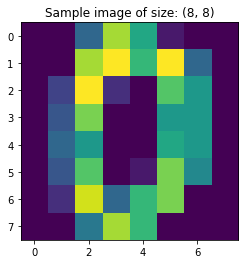


Image-as-vector; data shape:  (1797, 8, 8)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]

Vector-form data shape:  (1797, 64)


In [2]:
digits_data = load_digits()

print("Example image from MNIST dataset\n")
print(digits_data.images[0], '\n')
plt.figure()
plt.imshow(digits_data.images[0])
plt.title("Sample image of size: "+str(digits_data.images[0].shape))
plt.show()

print("\nImage-as-vector; data shape: ", digits_data.images.shape)
print(digits_data.data[0])
print("\nVector-form data shape: ", digits_data.data.shape)


The cell below shows the target shape. This is a numpy array, which has a list of integer values. These integers in turn represent the class labels, which in this case is the list of digits (the Indian numerals 0-9).

In [4]:
digits_data.target

array([0, 1, 2, ..., 8, 9, 8])

## Data preparation for model

1. We extract the number of unique classes `n_classes` from the target vector (in `data.target`)
2. We then prepare the `X` and `y` tensors of the dataset and make them suitable for training
3. Using Scikit-Learn's `train_test_split()` function, we can build training and test datasets from these `X` and `y` tensors

**Notes:** 

1. In the below code, we have used the vector representations of the MNIST images and reshaped them. This may not be required if we were to use the list of images as described above.
2. We have used the `get_dummies()` function from `pandas` to conveniently transform the target vector `y` to multiple columns of dummy variables. We have then coverted this to a `numpy` array using the `as_matrix()` method. Essentially, what we have accomplished here, is going between Numpy and Pandas to accomplish some convenient transformation tasks. In real world data science, we might write transformation functions to perform the same activities. The presence of convenient vectorized methods in pandas and numpy helps in this case.


In [6]:
n_classes = len(np.unique(digits_data.target))

X = digits_data.data.reshape((len(digits_data.data), 8,8,1)) # Alternatively, we can choose the images themselves represented as 8x8 matrices

y = digits_data.target

xtr, xts, y_tr, y_ts = train_test_split(X, y, test_size = 0.3) # Splitting the dataset into train and test sets using a test_size of 30% of the total data

ytr = pd.get_dummies(pd.Series(y_tr)).as_matrix()
yts = pd.get_dummies(pd.Series(y_ts)).as_matrix()

# Defining a Classification Model: Deep Convolutional Network

1. The 2D convolution layer `Conv2D()` from Keras allows us to learn 10 different filters which help make sense of the data which in this case has 10 classes
2. Key variables to be passed to this layer include the input shape (to be passed as $(8,8,1)$ - see above for the reshape operation which accomplishes this)
3. We also set an activation function, in this case, we have used a Rectified Linear Unit (`relu`)
4. What's also important is to use regularization in the model to prevent overfitting. We have used both $L_1$ and $L_2$ regularization in this model
5. We have provided a `MaxPool2D()` layer next, which allows us to reduce the numerosity of the same-convoluted data (observe the padding style used for `Conv2D()`)
6. Using batch normalization is an excellent practice when we build complex models. It normalizes the weights in the units of the network, and allows gradient descent to operate faster, thereby enabling higher learning rates.
7. Finally, we have `Flatten()` layers which takes a pooled tensor and compresses it into a vector. This vector is then fed to a `Dense()` layer

**Note:** The `Dense()` layer at the end has a `sigmoid` activation function, and 10 units, which allows us to train this layer to recognize the 10 classes of the dataset. Similarly, the `Conv2D()` layer at the start of the network has a specific `input_shape` argument, which allows is to read the data in the form provided. These two shapes are very key criteria when specifying any CNN network (or indeed any deep learning network).



In [7]:
model = Sequential([
    Conv2D(filters = 10, kernel_size = (2,2), input_shape = (8,8,1), activation='relu', padding= 'same', kernel_regularizer= l1_l2(l1=0.1, l2 = 0.1)),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Flatten(),
    Dense(n_classes, activation="sigmoid")
])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 10)          50        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 10)          40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1610      
Total params: 1,700
Trainable params: 1,680
Non-trainable params: 20
_________________________________________________________________


## Compiling and Fitting the Model

1. Here, we declare an optimizer object, based on the Adam optimizer (stochastic gradient descent with adaptive momentum estimation), which allows us to specify a starting value for the learning rate `lr` and the `decay`
2. The optimizer thus allows us to gradually reduce the learning rate as the model is trained over numerous epochs. This allows us to more subtly tweak the model's weights.
3. This kind of tweaking is important, since it allows us to converge to a result faster.
4. We also declare the kind of loss function the model should use in the gradient descent process. In this case, we specify `categorical_crossentropy` since the model is a multi-class classification model
5. The final variable to specify in the compilation step is the metric to be included in the callback. We choose `accuracy` as the metric of interest, because this is relevant for a classification problem

Once the model has been compiled, we run it with `batch_size` and `epochs` values of 8 and 128 respectively. We also pass validation data in the form of a list: `[xts, yts]`.

In [9]:
opt = Adam(lr=1e-3, decay=1e-4)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics = ['accuracy'])

In [10]:
history = model.fit(x = xtr, y = ytr, batch_size= 8, epochs= 512, validation_data= [xts, yts] )

Train on 1257 samples, validate on 540 samples
Epoch 1/512
1257/1257 [==============================] - 1s 773us/step - loss: 2.1611 - acc: 0.4956 - val_loss: 1.4291 - val_acc: 0.8130
Epoch 2/512
1257/1257 [==============================] - 0s 361us/step - loss: 0.8823 - acc: 0.8679 - val_loss: 0.9497 - val_acc: 0.8796
Epoch 3/512
1257/1257 [==============================] - 0s 356us/step - loss: 0.4712 - acc: 0.9332 - val_loss: 0.7161 - val_acc: 0.9315
Epoch 4/512
1257/1257 [==============================] - 0s 344us/step - loss: 0.3255 - acc: 0.9475 - val_loss: 0.6025 - val_acc: 0.8944
Epoch 5/512
1257/1257 [==============================] - 0s 324us/step - loss: 0.2679 - acc: 0.9586 - val_loss: 0.3152 - val_acc: 0.9519
Epoch 6/512
1257/1257 [==============================] - 0s 344us/step - loss: 0.1999 - acc: 0.9785 - val_loss: 0.3153 - val_acc: 0.9352
Epoch 7/512
1257/1257 [==============================] - 0s 374us/step - loss: 0.1934 - acc: 0.9730 - val_loss: 0.2193 - val_acc: 0

## Visualizing Loss and Accuracy Over the Training Process

It is helpful when building large deep learning models, to have a clear, step-by-step understanding of how the loss value from the model changes. This helps us understand the following:
1. Whether the model is overfitting
2. Whether the model is learning (if (a valid) loss function is decreasing constantly with epochs, it is learning by the weights being tweaked)
3. Whether the learning rate is too high, or too low
4. Whether the number of epochs is too high, or too low

... and many more aspects of the model's performance can similarly be understood from the loss plots.

Similarly, we can see below the accuracy of the model on training and validation sets. This is helpful in a practical sense, because these accuracy scores can be tied back to the business setting where the deep net you're building can be used, and where that accuracy score may have some significance.

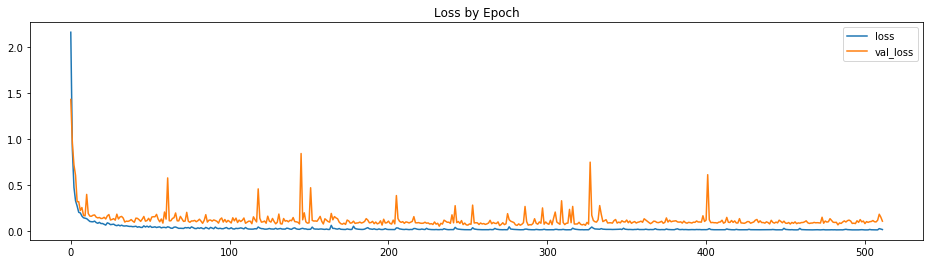

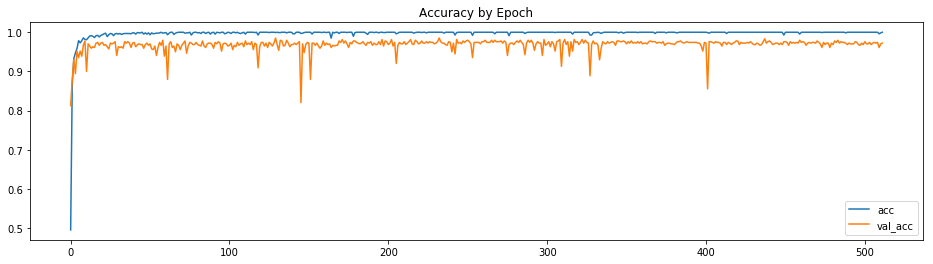

In [18]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (16,4), title = "Loss by Epoch");
pd.DataFrame(history.history)[['acc', 'val_acc']].plot(figsize = (16,4), title = "Accuracy by Epoch")

## Predictions and Visualizing Results

1. Observe that the predictions are one-hot matrices. These can be compared and scored only when we have unpivoted them (reverted them to their original form)
2. Once this is done, the confusion matrices are plotted for the train and test datasets. This allows us to understand how much misclassification there is due to the model.

Here `pred_tr` and `pred_ts` are one-hot vectors which are predicted by the model. We convert them to pandas dataframes, and then use the `get_class()` function to convert them to lists of labels.


In [19]:
pred_tr = model.predict(xtr)
pred_ts = model.predict(xts)

In [20]:
pred_tr = pd.DataFrame(pred_tr, columns=[0,1,2,3,4,5,6,7,8,9])
pred_ts = pd.DataFrame(pred_ts, columns=[0,1,2,3,4,5,6,7,8,9])

In [21]:
def get_class(row):
    for c in pred_tr.columns:
        if row[c]==max(row):
            return c

In [22]:
train_pred = pred_tr.apply(get_class, axis=1)
test_pred = pred_ts.apply(get_class, axis=1)

In [23]:
print(train_pred.shape, test_pred.shape)

(1257,) (540,)


Confusion matrix for the training data: 

[[122   0   0   0   0   0   0   0   0   0]
 [  0 141   0   0   0   0   0   0   0   0]
 [  0   0 119   0   0   0   0   0   0   0]
 [  0   0   0 135   0   0   0   0   0   0]
 [  0   0   0   0 134   0   0   0   0   0]
 [  0   0   0   0   0 118   0   0   0   0]
 [  0   0   0   0   0   0 116   0   0   0]
 [  0   0   0   0   0   0   0 116   0   0]
 [  0   0   0   0   0   0   0   0 128   0]
 [  0   0   0   0   0   0   0   0   0 128]]


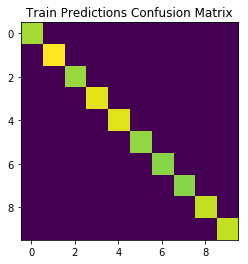


Confusion matrix for the test data: 

[[55  0  0  0  1  0  0  0  0  0]
 [ 0 41  0  0  0  0  0  0  0  0]
 [ 0  3 55  0  0  0  0  0  0  0]
 [ 0  0  0 48  0  0  0  0  0  0]
 [ 0  2  0  0 44  0  0  0  0  1]
 [ 0  0  0  0  1 61  0  0  0  2]
 [ 0  3  0  0  0  0 62  0  0  0]
 [ 0  0  0  1  0  0  0 62  0  0]
 [ 0  0  0  0  0  0  0  0 46  0]
 [ 0  0  0  1  0  0  0  0  0 51]]


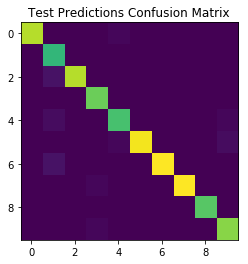

In [24]:
print("Confusion matrix for the training data: \n")
print(confusion_matrix(y_tr, train_pred))
plt.imshow(confusion_matrix(y_tr, train_pred))
plt.title("Train Predictions Confusion Matrix")
plt.show()
print ("\nConfusion matrix for the test data: \n")
print(confusion_matrix(y_ts, test_pred))
plt.imshow(confusion_matrix(y_ts, test_pred))
plt.title("Test Predictions Confusion Matrix")
plt.show()